In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from numpy import cov
import xarray as xr
import scipy.stats as stats
import math
from scipy.stats import linregress
import numpy.polynomial.polynomial as poly
from sklearn.linear_model import LinearRegression
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import cartopy.io.img_tiles as cimgt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy import config
from matplotlib.transforms import offset_copy
%matplotlib inline
import cmocean
import glob
from scipy.io import netcdf_file as netcdf
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from shapely import geometry
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import integrate
import scipy as sci
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from scipy.stats import kde
from scipy import signal
import metpy.calc as mpc
import matplotlib.pylab as pl
from metpy.units import units
import pymannkendall as mk

In [2]:
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
omega = 1.41e-4 #tidal frequency
T_e = np.pi/omega 
T = 2*np.pi/omega 
Pr = 14
Sc = 1500
nu = 2.0e-6
alpha = 3.8e-5
beta = 7.8e-4
Xi = 0.052
vonk = 0.41
Rc = 0.2
rho0 = 1030

In [5]:
s_df = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes/ISOBL_model_output.nc')

In [6]:
se_df = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes-ekman/ISOBL_model_output.nc')

In [7]:
e_df = xr.open_dataset('C:/Users/bajus/Downloads/ISOBL_model_output.nc')

In [8]:
def ustar_calc(ubar, wbar, y, nu, rho):
            
    spd = (ubar**2+wbar**2)**0.5
    dUdy = (((ubar[:,2]-ubar[:,1])/(y[2]-y[1]))**2+((wbar[:,2]-wbar[:,1])/(y[2]-y[1]))**2)**0.5
    
    tau_w = rho*nu*(dUdy)
    ustar = (tau_w/rho)**0.5
    return ustar

In [9]:
s_ustar = ustar_calc(s_df['U'].data, s_df['W'].data, s_df['y'].data, nu, rho0)
se_ustar = ustar_calc(se_df['U'].data, se_df['W'].data, se_df['y'].data, nu, rho0)
e_ustar = ustar_calc(e_df['U'].data, e_df['W'].data, e_df['y'].data, nu, rho0)

In [10]:
def cycle_average_1d(var, time, omega, start_cycle, end_cycle, dt):
    import numpy as np
    
    T = 2*np.pi/omega
    NT = int(np.floor(T/dt))
    #print(NT)
    t_cycle = np.linspace(0, T, NT)
    
    if np.floor(time[-2]/T)<end_cycle:
        print('record not', end_cycle, ' cycles long!!')
        return
    
    var_cycle = np.zeros(len(t_cycle))
    
    for ii in range(start_cycle,end_cycle):
        ttmp = time - ii*T
        tmp = np.interp(t_cycle, ttmp, var)
        var_cycle = var_cycle+tmp
        
    var_cycle = var_cycle/(end_cycle-start_cycle)
    return t_cycle, var_cycle

In [11]:
s_ustar_cycle_max = np.max(cycle_average_1d(s_ustar, s_df['t'], omega, 3, 6, 100)[1])
se_ustar_cycle_max = np.max(cycle_average_1d(se_ustar, se_df['t'], omega, 3, 6, 100)[1])

In [12]:
s_ustar_cycle_max

0.001220460870511601

In [13]:
se_ustar_cycle_max

0.0008596842144701706

In [14]:
N0_e = np.sqrt(3.06072334e-06)
u0_e = 2.8e-2
f_e = 2.74e-4
corio_e = f_e

N0_s = np.sqrt(3.07286646e-06)
u0_s = 0.00013403

N0_se = np.sqrt(3.06057076e-06)
u0_se = 0.00063434

f = 1.37e-4
corio = f

In [29]:
e_df['y'] = e_df['y']/((0.05*u0_e)/np.sqrt(f_e*N0_e))

In [30]:
s_df['y'] = s_df['y']/((s_ustar_cycle_max)/np.sqrt(f*N0_s))

In [31]:
se_df['y'] = se_df['y']/((se_ustar_cycle_max)/np.sqrt(f*N0_se))

In [32]:
s_df['y']

<xarray.DataArray 'y' (y: 430)>
array([2.866393e-04, 8.631245e-04, 1.446058e-03, ..., 3.967403e+00,
       3.996584e+00, 4.025859e+00])
Coordinates:
  * y        (y) float64 0.0002866 0.0008631 0.001446 ... 3.967 3.997 4.026

In [33]:
se_df['y']

<xarray.DataArray 'y' (y: 430)>
array([4.065232e-04, 1.224117e-03, 2.050857e-03, ..., 5.626727e+00,
       5.668113e+00, 5.709633e+00])
Coordinates:
  * y        (y) float64 0.0004065 0.001224 0.002051 ... 5.627 5.668 5.71

In [15]:
s_dUdy = s_df['U'].differentiate('y')
s_dWdy = s_df['W'].differentiate('y')

se_dUdy = se_df['U'].differentiate('y')
se_dWdy = se_df['W'].differentiate('y')

In [16]:
s_S2 = s_dUdy**2 + s_dWdy**2
se_S2 = se_dUdy**2 + se_dWdy**2

In [17]:
s_Ri = s_df['N2']/s_S2
se_Ri = se_df['N2']/se_S2

In [18]:
s_ds = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes/mean_prof_stat.nc')
se_ds = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes-ekman/mean_prof_stat.nc')

In [19]:
### remove duplicated y and t values - this is applied to all the variables in the dataset
_, index = np.unique(s_ds['y'], return_index=True)
s_dtmp = s_ds.isel(y=index)

_, index = np.unique(s_ds['t'], return_index=True)
s_dtmp = s_dtmp.isel(t=index)

### remove anything with a nan in coordinate "t" (time)
idx = np.squeeze(np.argwhere(~np.isnan(s_dtmp.t.values)))
s_dtmp = s_dtmp.isel(t=idx)

In [20]:
nhours = ((s_dtmp.t[-2]-s_dtmp.t[1])/3600)
NT = len(s_ds.t)
dT_minutes = 10
NT_light = int(nhours.round()*(60/dT_minutes))
if NT>NT_light:
    print('yep, sub-sampling in t')
    t_light = np.linspace(s_dtmp.t[1],s_dtmp.t[-2],NT_light)
    s_dtmp = s_dtmp.sel(t=t_light, method='nearest')

yep, sub-sampling in t


In [21]:
## domain unnecessarily deep for some of my early simulations. Restrict to 10 m
ymax = 10
if s_dtmp.y[-2]>ymax:
    s_dtmp = s_dtmp.sel(y=slice(None, 10.05))
    print('yep, sub-sampling in y')

yep, sub-sampling in y


In [22]:
### remove duplicated y and t values - this is applied to all the variables in the dataset
_, index = np.unique(se_ds['y'], return_index=True)
se_dtmp = se_ds.isel(y=index)

_, index = np.unique(se_ds['t'], return_index=True)
se_dtmp = se_dtmp.isel(t=index)

### remove anything with a nan in coordinate "t" (time)
idx = np.squeeze(np.argwhere(~np.isnan(se_dtmp.t.values)))
se_dtmp = se_dtmp.isel(t=idx)

In [23]:
nhours = ((se_dtmp.t[-2]-se_dtmp.t[1])/3600)
NT = len(se_ds.t)
dT_minutes = 10
NT_light = int(nhours.round()*(60/dT_minutes))
if NT>NT_light:
    print('yep, sub-sampling in t')
    t_light = np.linspace(se_dtmp.t[1],se_dtmp.t[-2],NT_light)
    se_dtmp = se_dtmp.sel(t=t_light, method='nearest')

yep, sub-sampling in t


In [24]:
## domain unnecessarily deep for some of my early simulations. Restrict to 10 m
ymax = 10
if se_dtmp.y[-2]>ymax:
    se_dtmp = se_dtmp.sel(y=slice(None, 10.05))
    print('yep, sub-sampling in y')

yep, sub-sampling in y


In [25]:
s_u_star = (s_dtmp['uv']**2 + s_dtmp['wv']**2)**(1/4)
se_u_star = (se_dtmp['uv']**2 + se_dtmp['wv']**2)**(1/4)

In [26]:
s_speed = (s_df['U']**2 + s_df['W']**2)**(1/2)
se_speed = (se_df['U']**2 + se_df['W']**2)**(1/2)

In [27]:
e_dUdy = e_df['U'].differentiate('y')
e_dWdy = e_df['W'].differentiate('y')

e_S2 = e_dUdy**2 + e_dWdy**2

e_Ri = e_df['N2']/e_S2

e_u_star = (e_df['uv']**2 + e_df['wv']**2)**(1/4)

e_speed = (e_df['U']**2 + e_df['W']**2)**(1/2)

<ipython-input-36-10652e33efea>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CS1 = ax1.pcolor(s_df['t']/T, s_df['y'], s_df['N2'].transpose(), cmap='BrBG_r', vmin = -1e-5, vmax =1e-5)
<ipython-input-36-10652e33efea>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CS2 = ax2.pcolor(se_df['t']/T, se_df['y'], se_df['N2'].transpose(), cmap='BrBG_r', vmin = -1e-5, vmax =1e-5)
<ipython-input-36-10652e33efea>:72: MatplotlibDeprecationWarning: shading='flat' wh

<ipython-input-36-10652e33efea>:367: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CS5_1 = ax5_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_S2.transpose(), cmap='cmo.algae',vmin=0,vmax=5e-5)
<ipython-input-36-10652e33efea>:382: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CS7_1 = ax7_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_Ri.transpose(), cmap='afmhot',vmin=0,vmax=0.4)
<ipython-input-36-10652e33efea>:397: MatplotlibDeprecationWarning: shading

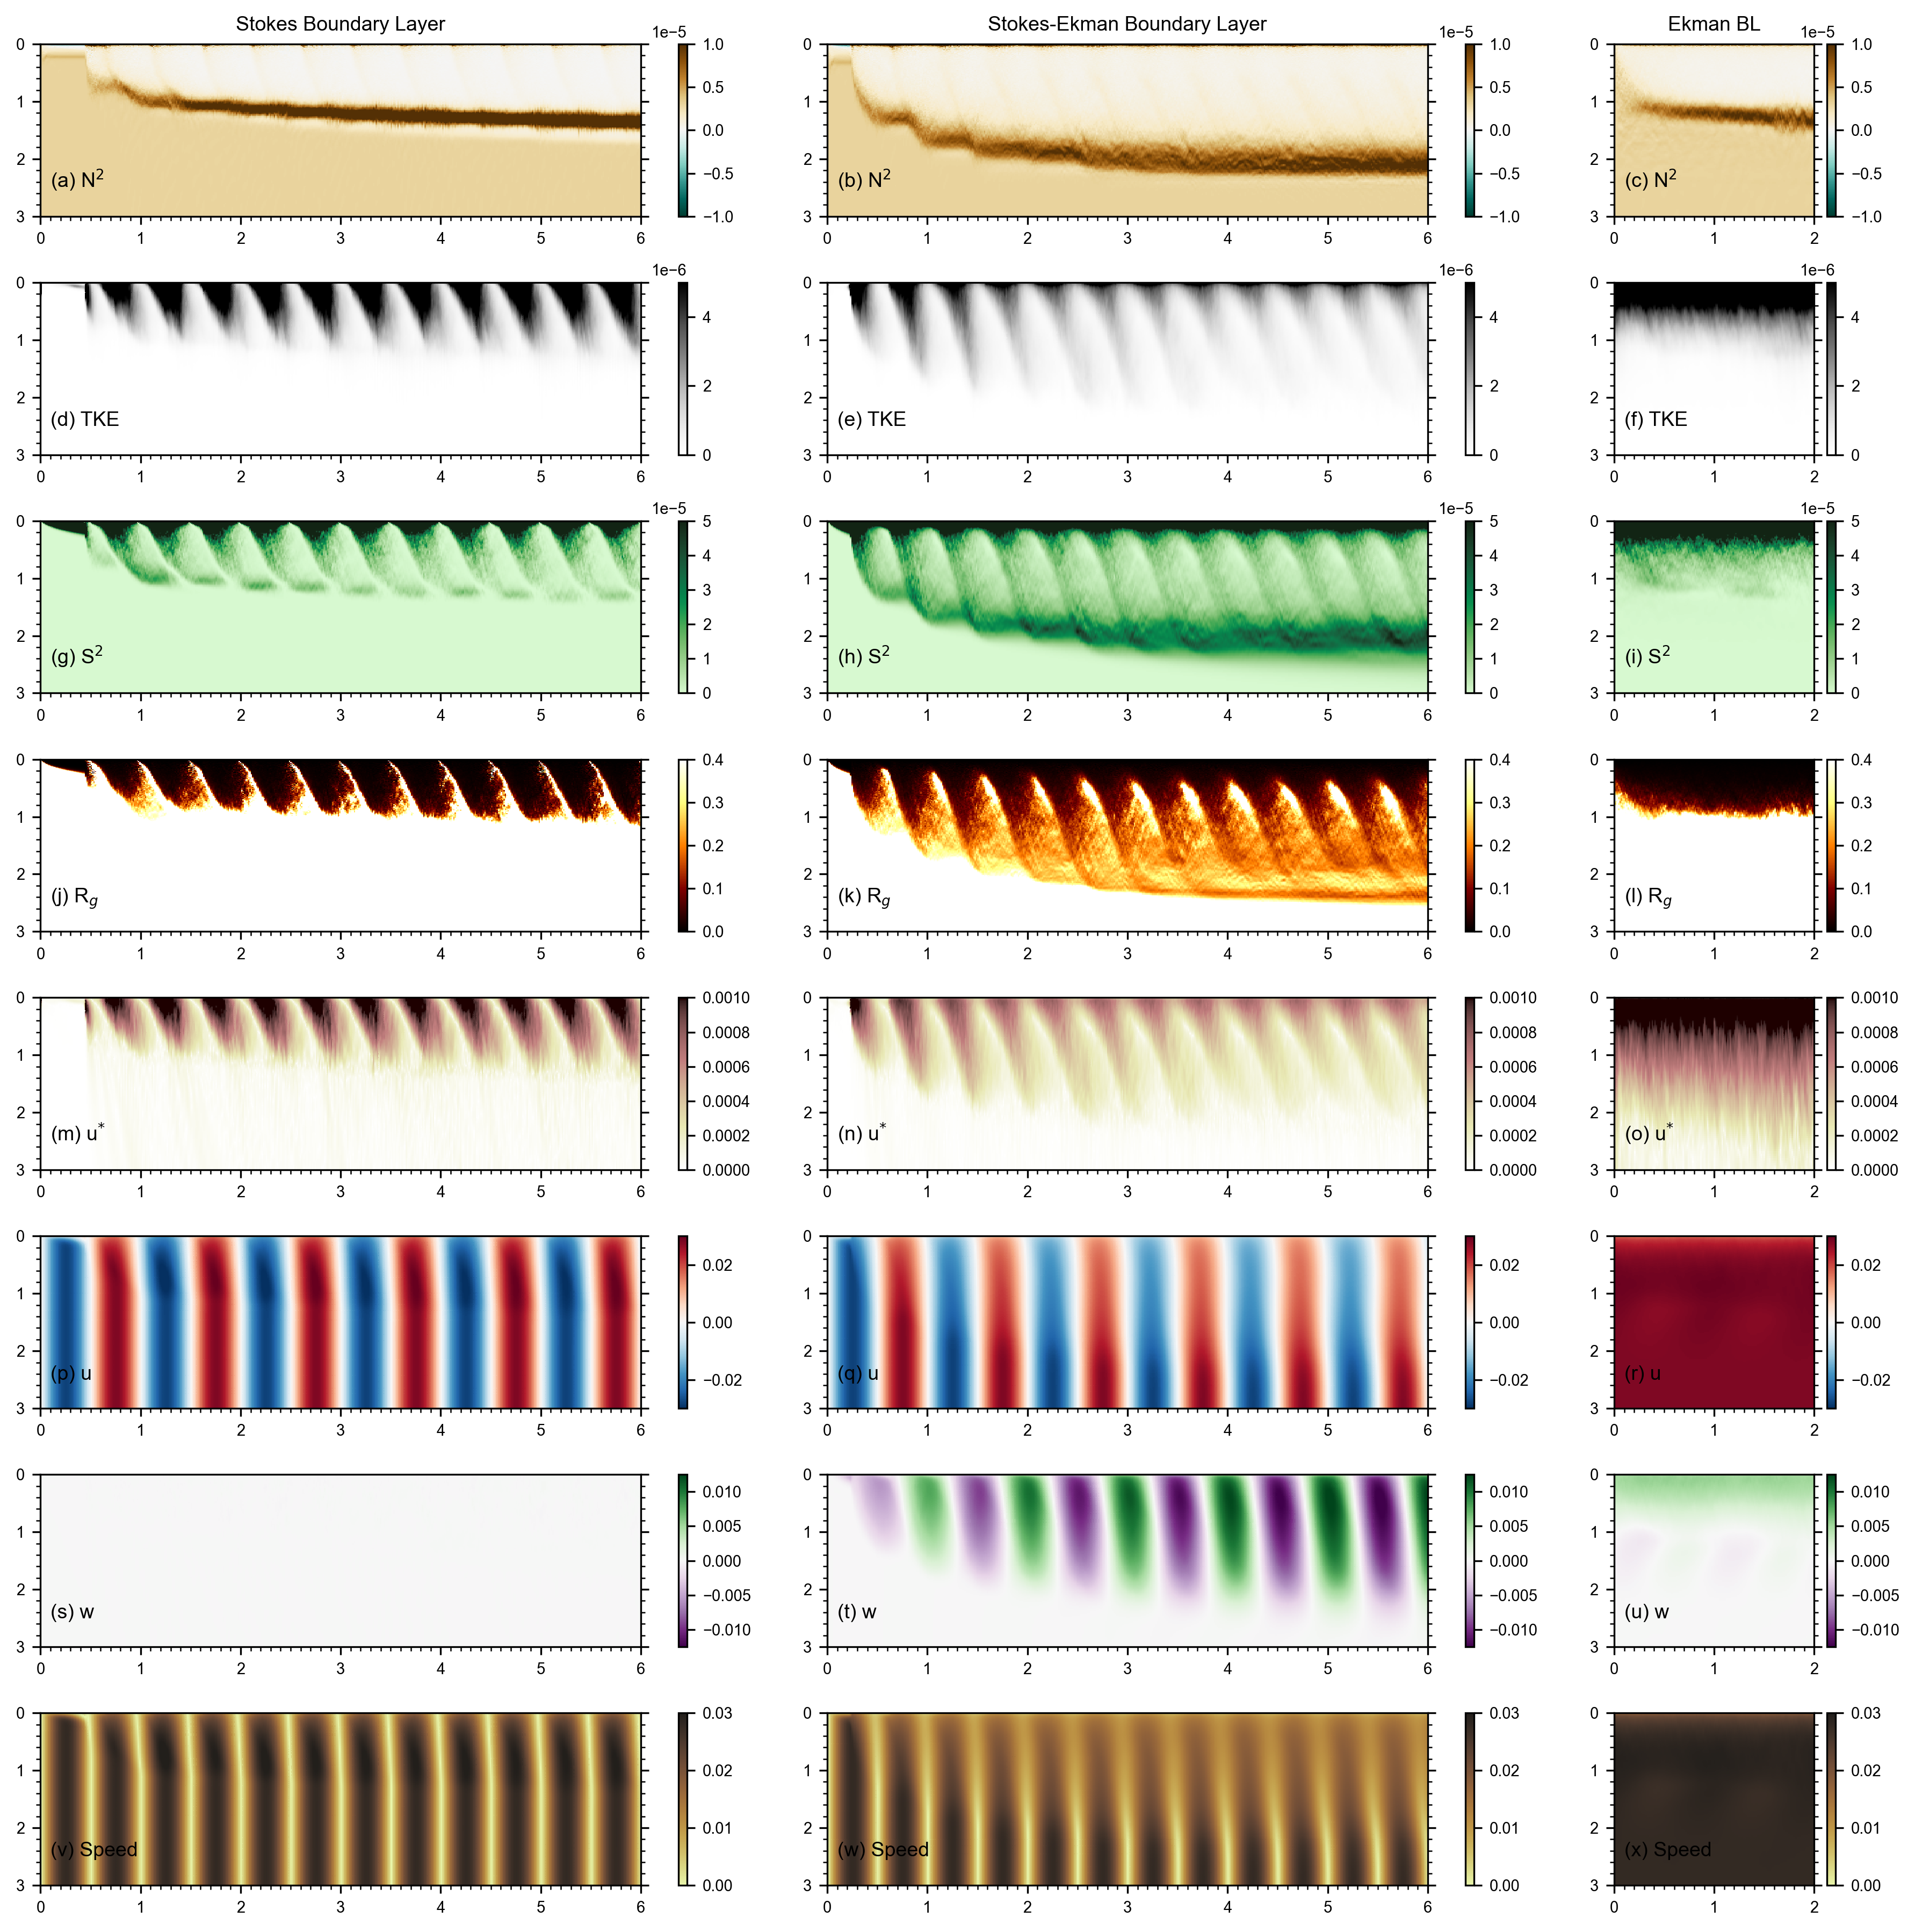

In [36]:
fig = plt.figure(figsize=(12,12))



gs = fig.add_gridspec(8,3,width_ratios=[6,6,2])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax1_1 = fig.add_subplot(gs[0,2])

ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax3_1 = fig.add_subplot(gs[1,2])

ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])
ax5_1 = fig.add_subplot(gs[2,2])

ax7 = fig.add_subplot(gs[3,0])
ax8 = fig.add_subplot(gs[3,1])
ax7_1 = fig.add_subplot(gs[3,2])

ax9 = fig.add_subplot(gs[4,0])
ax10 = fig.add_subplot(gs[4,1])
ax9_1 = fig.add_subplot(gs[4,2])

ax11 = fig.add_subplot(gs[5,0])
ax12 = fig.add_subplot(gs[5,1])
ax11_1 = fig.add_subplot(gs[5,2])

ax13 = fig.add_subplot(gs[6,0])
ax14 = fig.add_subplot(gs[6,1])
ax13_1 = fig.add_subplot(gs[6,2])

ax15 = fig.add_subplot(gs[7,0])
ax16 = fig.add_subplot(gs[7,1])
ax15_1 = fig.add_subplot(gs[7,2])



CS1 = ax1.pcolor(s_df['t']/T, s_df['y'], s_df['N2'].transpose(), cmap='BrBG_r', vmin = -1e-5, vmax =1e-5)

ax1.set_ylim(3,0)

ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS1,ax=ax1,pad=0.05)



CS2 = ax2.pcolor(se_df['t']/T, se_df['y'], se_df['N2'].transpose(), cmap='BrBG_r', vmin = -1e-5, vmax =1e-5)

ax2.set_ylim(3,0)

ax2.yaxis.set_minor_locator(MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))

ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS2,ax=ax2,pad=0.05)




CS3 = ax3.pcolor(s_df['t']/T, s_df['y'], s_df['TKE'].transpose(), cmap='Greys', vmin = 0, vmax = 5e-6)

ax3.set_ylim(3,0)

ax3.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.xaxis.set_minor_locator(MultipleLocator(0.1))

ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS3,ax=ax3,pad=0.05)



CS4 = ax4.pcolor(se_df['t']/T, se_df['y'], se_df['TKE'].transpose(), cmap='Greys', vmin = 0, vmax = 5e-6)

ax4.set_ylim(3,0)

ax4.yaxis.set_minor_locator(MultipleLocator(0.2))
ax4.xaxis.set_minor_locator(MultipleLocator(0.1))

ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS4,ax=ax4,pad=0.05)



CS5 = ax5.pcolor(s_df['t']/T, s_df['y'], s_S2.transpose(), cmap='cmo.algae',vmin=0,vmax=5e-5)

ax5.set_ylim(3,0)

ax5.yaxis.set_minor_locator(MultipleLocator(0.2))
ax5.xaxis.set_minor_locator(MultipleLocator(0.1))

ax5.yaxis.set_major_locator(MultipleLocator(1))
ax5.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS5,ax=ax5,pad=0.05)



CS6 = ax6.pcolor(se_df['t']/T, se_df['y'], se_S2.transpose(), cmap='cmo.algae',vmin=0,vmax=5e-5)

ax6.set_ylim(3,0)

ax6.yaxis.set_minor_locator(MultipleLocator(0.2))
ax6.xaxis.set_minor_locator(MultipleLocator(0.1))

ax6.yaxis.set_major_locator(MultipleLocator(1))
ax6.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS6,ax=ax6,pad=0.05)



CS7 = ax7.pcolor(s_df['t']/T, s_df['y'], s_Ri.transpose(), cmap='afmhot',vmin=0,vmax=0.4)

ax7.set_ylim(3,0)

ax7.yaxis.set_minor_locator(MultipleLocator(0.2))
ax7.xaxis.set_minor_locator(MultipleLocator(0.1))

ax7.yaxis.set_major_locator(MultipleLocator(1))
ax7.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS7,ax=ax7,pad=0.05)



CS8 = ax8.pcolor(se_df['t']/T, se_df['y'], se_Ri.transpose(), cmap='afmhot',vmin=0,vmax=0.4)

ax8.set_ylim(3,0)

ax8.yaxis.set_minor_locator(MultipleLocator(0.2))
ax8.xaxis.set_minor_locator(MultipleLocator(0.1))

ax8.yaxis.set_major_locator(MultipleLocator(1))
ax8.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS8,ax=ax8,pad=0.05)



CS9 = ax9.pcolor(s_df['t']/T, s_df['y'], s_u_star.transpose(), cmap='pink_r',vmin=0,vmax=1e-3)

ax9.set_ylim(3,0)

ax9.yaxis.set_minor_locator(MultipleLocator(0.2))
ax9.xaxis.set_minor_locator(MultipleLocator(0.1))

ax9.yaxis.set_major_locator(MultipleLocator(1))
ax9.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS9,ax=ax9,pad=0.05)


CS10 = ax10.pcolor(se_df['t']/T, se_df['y'], se_u_star.transpose(), cmap='pink_r',vmin=0,vmax=1e-3)

ax10.set_ylim(3,0)

ax10.yaxis.set_minor_locator(MultipleLocator(0.2))
ax10.xaxis.set_minor_locator(MultipleLocator(0.1))

ax10.yaxis.set_major_locator(MultipleLocator(1))
ax10.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS10,ax=ax10,pad=0.05)



CS11 = ax11.pcolor(s_df['t']/T, s_df['y'], s_df['U'].transpose(), cmap='RdBu_r',vmax=0.03,vmin=-0.03)

ax11.set_ylim(3,0)

ax11.yaxis.set_minor_locator(MultipleLocator(0.2))
ax11.xaxis.set_minor_locator(MultipleLocator(0.1))

ax11.yaxis.set_major_locator(MultipleLocator(1))
ax11.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS11,ax=ax11,pad=0.05)


CS12 = ax12.pcolor(se_df['t']/T, se_df['y'], se_df['U'].transpose(), cmap='RdBu_r',vmax=0.03,vmin=-0.03)

ax12.set_ylim(3,0)

ax12.yaxis.set_minor_locator(MultipleLocator(0.2))
ax12.xaxis.set_minor_locator(MultipleLocator(0.1))

ax12.yaxis.set_major_locator(MultipleLocator(1))
ax12.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS12,ax=ax12,pad=0.05)



CS13 = ax13.pcolor(s_df['t']/T, s_df['y'], s_df['W'].transpose(), cmap='PRGn',vmax=1.25e-2,vmin=-1.25e-2)

ax13.set_ylim(3,0)

ax13.yaxis.set_minor_locator(MultipleLocator(0.2))
ax13.xaxis.set_minor_locator(MultipleLocator(0.1))

ax13.yaxis.set_major_locator(MultipleLocator(1))
ax13.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS13,ax=ax13,pad=0.05)


CS14 = ax14.pcolor(se_df['t']/T, se_df['y'], se_df['W'].transpose(), cmap='PRGn',vmax=1.25e-2,vmin=-1.25e-2)

ax14.set_ylim(3,0)

ax14.yaxis.set_minor_locator(MultipleLocator(0.2))
ax14.xaxis.set_minor_locator(MultipleLocator(0.1))

ax14.yaxis.set_major_locator(MultipleLocator(1))
ax14.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS14,ax=ax14,pad=0.05)



CS15 = ax15.pcolor(s_df['t']/T, s_df['y'], s_speed.transpose(), cmap='cmo.turbid',vmax=3e-2,vmin=0)

ax15.set_ylim(3,0)

ax15.yaxis.set_minor_locator(MultipleLocator(0.2))
ax15.xaxis.set_minor_locator(MultipleLocator(0.1))

ax15.yaxis.set_major_locator(MultipleLocator(1))
ax15.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS15,ax=ax15,pad=0.05)


CS16 = ax16.pcolor(se_df['t']/T, se_df['y'], se_speed.transpose(), cmap='cmo.turbid',vmax=3e-2,vmin=0)

ax16.set_ylim(3,0)

ax16.yaxis.set_minor_locator(MultipleLocator(0.2))
ax16.xaxis.set_minor_locator(MultipleLocator(0.1))

ax16.yaxis.set_major_locator(MultipleLocator(1))
ax16.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS16,ax=ax16,pad=0.05)



ax1.set_xlim(0,6)
ax2.set_xlim(0,6)
ax3.set_xlim(0,6)
ax4.set_xlim(0,6)
ax5.set_xlim(0,6)
ax6.set_xlim(0,6)
ax7.set_xlim(0,6)
ax8.set_xlim(0,6)
ax9.set_xlim(0,6)
ax10.set_xlim(0,6)
ax11.set_xlim(0,6)
ax12.set_xlim(0,6)
ax13.set_xlim(0,6)
ax14.set_xlim(0,6)
ax15.set_xlim(0,6)
ax16.set_xlim(0,6)

ax1.annotate(r'(a) N$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax2.annotate(r'(b) N$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax3.annotate(r'(d) TKE',xy=(0.1,2.5),fontsize=9,color='black')
ax4.annotate(r'(e) TKE',xy=(0.1,2.5),fontsize=9,color='black')
ax5.annotate(r'(g) S$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax6.annotate(r'(h) S$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax7.annotate(r'(j) R$_{g}$',xy=(0.1,2.5),fontsize=9,color='black')
ax8.annotate(r'(k) R$_{g}$',xy=(0.1,2.5),fontsize=9,color='black')
ax9.annotate(r'(m) u$^{*}$',xy=(0.1,2.5),fontsize=9,color='black')
ax10.annotate(r'(n) u$^{*}$',xy=(0.1,2.5),fontsize=9,color='black')
ax11.annotate(r'(p) u',xy=(0.1,2.5),fontsize=9,color='black')
ax12.annotate(r'(q) u',xy=(0.1,2.5),fontsize=9,color='black')
ax13.annotate(r'(s) w',xy=(0.1,2.5),fontsize=9,color='black')
ax14.annotate(r'(t) w',xy=(0.1,2.5),fontsize=9,color='black')
ax15.annotate(r'(v) Speed',xy=(0.1,2.5),fontsize=9,color='black')
ax16.annotate(r'(w) Speed',xy=(0.1,2.5),fontsize=9,color='black')

ax1.set_title('Stokes Boundary Layer',fontsize=9)
ax2.set_title('Stokes-Ekman Boundary Layer',fontsize=9)

mpl.axes.Axes.tick_params(ax1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax2, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax3, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax4, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax5, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax6, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax7, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax8, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax9, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax10, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax11, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax12, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax13, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax14, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax15, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax16, which = 'both', bottom = True, top = False, left = True, right = True)






CS1_1 = ax1_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_df['N2'].transpose(), cmap='BrBG_r', vmin = -1e-5, vmax =1e-5)

ax1_1.set_ylim(3,0)

ax1_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax1_1.yaxis.set_major_locator(MultipleLocator(1))
ax1_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS1_1,ax=ax1_1,pad=0.05)



CS3_1 = ax3_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_df['TKE'].transpose(), cmap='Greys', vmin = 0, vmax = 5e-6)

ax3_1.set_ylim(3,0)

ax3_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax3_1.yaxis.set_major_locator(MultipleLocator(1))
ax3_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS3_1,ax=ax3_1,pad=0.05)



CS5_1 = ax5_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_S2.transpose(), cmap='cmo.algae',vmin=0,vmax=5e-5)

ax5_1.set_ylim(3,0)

ax5_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax5_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax5_1.yaxis.set_major_locator(MultipleLocator(1))
ax5_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS5_1,ax=ax5_1,pad=0.05)



CS7_1 = ax7_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_Ri.transpose(), cmap='afmhot',vmin=0,vmax=0.4)

ax7_1.set_ylim(3,0)

ax7_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax7_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax7_1.yaxis.set_major_locator(MultipleLocator(1))
ax7_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS7_1,ax=ax7_1,pad=0.05)



CS9_1 = ax9_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_u_star.transpose(), cmap='pink_r',vmin=0,vmax=1e-3)

ax9_1.set_ylim(3,0)

ax9_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax9_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax9_1.yaxis.set_major_locator(MultipleLocator(1))
ax9_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS9_1,ax=ax9_1,pad=0.05)



CS11_1 = ax11_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_df['U'].transpose(), cmap='RdBu_r',vmax=0.03,vmin=-0.03)

ax11_1.set_ylim(3,0)

ax11_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax11_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax11_1.yaxis.set_major_locator(MultipleLocator(1))
ax11_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS11_1,ax=ax11_1,pad=0.05)



CS13_1 = ax13_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_df['W'].transpose(), cmap='PRGn',vmax=1.25e-2,vmin=-1.25e-2)

ax13_1.set_ylim(3,0)

ax13_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax13_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax13_1.yaxis.set_major_locator(MultipleLocator(1))
ax13_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS13_1,ax=ax13_1,pad=0.05)



CS15_1 = ax15_1.pcolor((e_df['t']/T_e)-0.85427268, e_df['y'], e_speed.transpose(), cmap='cmo.turbid',vmax=3e-2,vmin=0)

ax15_1.set_ylim(3,0)

ax15_1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax15_1.xaxis.set_minor_locator(MultipleLocator(0.1))

ax15_1.yaxis.set_major_locator(MultipleLocator(1))
ax15_1.xaxis.set_major_locator(MultipleLocator(1))


plt.colorbar(CS15_1,ax=ax15_1,pad=0.05)




ax1_1.set_xlim(0,2)
ax3_1.set_xlim(0,2)
ax5_1.set_xlim(0,2)
ax7_1.set_xlim(0,2)
ax9_1.set_xlim(0,2)
ax11_1.set_xlim(0,2)
ax13_1.set_xlim(0,2)
ax15_1.set_xlim(0,2)

ax1_1.annotate(r'(c) N$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax3_1.annotate(r'(f) TKE',xy=(0.1,2.5),fontsize=9,color='black')
ax5_1.annotate(r'(i) S$^{2}$',xy=(0.1,2.5),fontsize=9,color='black')
ax7_1.annotate(r'(l) R$_{g}$',xy=(0.1,2.5),fontsize=9,color='black')
ax9_1.annotate(r'(o) u$^{*}$',xy=(0.1,2.5),fontsize=9,color='black')
ax11_1.annotate(r'(r) u',xy=(0.1,2.5),fontsize=9,color='black')
ax13_1.annotate(r'(u) w',xy=(0.1,2.5),fontsize=9,color='black')
ax15_1.annotate(r'(x) Speed',xy=(0.1,2.5),fontsize=9,color='black')

ax1_1.set_title('Ekman BL',fontsize=9)

mpl.axes.Axes.tick_params(ax1_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax3_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax5_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax7_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax9_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax11_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax13_1, which = 'both', bottom = True, top = False, left = True, right = True)
mpl.axes.Axes.tick_params(ax15_1, which = 'both', bottom = True, top = False, left = True, right = True)




plt.tight_layout()
plt.show()